In [9]:
#pip install -r requirements.txt
#%pip install pandas
#%pip install numpy
%pip install cartopy
#

Note: you may need to restart the kernel to use updated packages.


Data Sources and Setup

In [10]:
# Import libraries for data handling
import netCDF4 as nc
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Define geographic boundaries for the UK (approximate)
lat_min_uk, lat_max_uk = 49.0, 61.0    # latitude range for UK
lon_min_uk, lon_max_uk = -8.5, 2.0     # longitude range for UK (note: negative for West)

# List of NetCDF data files for each climate index component
data_files = {
    "TX90p": "nc_data/GHCND_TX90p_1951-2025_RegularGrid_global_2.5x2.5deg_m4.nc",
    "TX10p": "nc_data/GHCND_TX10p_1951-2025_RegularGrid_global_2.5x2.5deg_m4.nc",
    "TN90p": "nc_data/GHCND_TN90p_1951-2025_RegularGrid_global_2.5x2.5deg_m4.nc",
    "TN10p": "nc_data/GHCND_TN10p_1951-2025_RegularGrid_global_2.5x2.5deg_m4.nc",
    "Rx5day": "nc_data/GHCND_Rx5day_1951-2025_RegularGrid_global_2.5x2.5deg_m4.nc",
    "CDD": "nc_data/GHCND_CDD_1951-2025_RegularGrid_global_2.5x2.5deg_m4.nc"
}


# Open each NetCDF file and store the dataset
datasets = {name: nc.Dataset(path) for name, path in data_files.items()}

# For convenience, extract the coordinate arrays (assume all share same grid)
lats = datasets["TX90p"].variables["lat"][:]
lons = datasets["TX90p"].variables["lon"][:]

print(f"Latitude array sample: {lats[:5]} ... {lats[-5:]}")
print(f"Longitude array sample: {lons[:5]} ... {lons[-5:]}")


Latitude array sample: [-90.  -87.5 -85.  -82.5 -80. ] ... [80.  82.5 85.  87.5 90. ]
Longitude array sample: [ 0.   2.5  5.   7.5 10. ] ... [347.5 350.  352.5 355.  357.5]


In [11]:
# Find index range for latitudes within UK bounds
lat_indices = np.where((lats >= lat_min_uk) & (lats <= lat_max_uk))[0]

# Find index range for longitudes within UK bounds (accounting for wrap-around)
if lon_min_uk < 0:
    lon_min_mod = lon_min_uk + 360.0  # e.g., -8.5 -> 351.5
else:
    lon_min_mod = lon_min_uk
if lon_min_mod <= lon_max_uk:
    # If the range does not cross the 0 meridian
    lon_indices = np.where((lons >= lon_min_mod) & (lons <= lon_max_uk))[0]
else:
    # Range crosses 0°E (i.e., includes 360->... and 0->...)
    lon_indices = np.where((lons >= lon_min_mod) | (lons <= lon_max_uk))[0]

print(f"Selected latitude indices: {lat_indices.min()} to {lat_indices.max()} (lat ~{lats[lat_indices.min()]}° to {lats[lat_indices.max()]}°)")
print(f"Selected longitude indices: {lon_indices.min()} to {lon_indices.max()} (lon ~{lons[lon_indices.min()]}° to {lons[lon_indices.max()]}°)")


Selected latitude indices: 56 to 60 (lat ~50.0° to 60.0°)
Selected longitude indices: 0 to 143 (lon ~0.0° to 357.5°)


In [12]:
# Determine the years from the time variable (assuming format YYYY0101 as integer)
time_vals = datasets["TX90p"].variables["time"][:]  # e.g., [19510101, 19520101, ...]
years = (time_vals // 10000).astype(int)  # extract the year part

# Initialize a dictionary to store UK annual series for each index
uk_annual_series = {}

for name, ds in datasets.items():
    # Annual values for all years and all grid cells
    annual_data = ds.variables["Ann"][:]  # shape: [time, lat, lon]
    # Subset to UK region grid cells
    uk_region_data = annual_data[:, lat_indices.min():lat_indices.max()+1, lon_indices.min():lat_indices.max()+1]
    # Compute spatial average over the region (mean over lat and lon dimensions)
    uk_mean = np.nanmean(uk_region_data, axis=(1, 2))
    uk_annual_series[name] = uk_mean

# Convert to pandas DataFrame for convenience
uk_df = pd.DataFrame(uk_annual_series, index=years)
uk_df.index.name = "Year"

# Calculate the average temperature index
uk_df['Temperature_Avg'] = uk_df[['TN90p', 'TN10p', 'TX90p', 'TX10p']].mean(axis=1)

# Remove the TX and TN columns
uk_df = uk_df.drop(columns=['TX90p', 'TX10p', 'TN90p', 'TN10p'])

# Quick check of the DataFrame
print(uk_df.head(5))
print("...\n", uk_df.tail(5))


         Rx5day        CDD  Temperature_Avg
Year                                       
1951  56.524963  41.407883        10.491491
1952  56.396206  37.348179        11.487964
1953  56.757263  35.683254        10.460924
1954  57.824585  34.553654        10.983292
1955  54.464020  32.838455        12.066027
...
          Rx5day        CDD  Temperature_Avg
Year                                       
2021  78.285652  22.909502        11.517701
2022  67.818787  25.083065        10.618366
2023  74.185112  25.023527        13.270541
2024  69.981323  20.226109        15.397078
2025        NaN        NaN              NaN


Computing ACI Components and Anomalies

In [13]:
# Define baseline reference period
ref_start, ref_end = 1961, 1990
baseline_mask = (uk_df.index >= ref_start) & (uk_df.index <= ref_end)

# Calculate mean and std for each component over the reference period
baseline_means = uk_df[baseline_mask].mean()
baseline_stds  = uk_df[baseline_mask].std(ddof=0)  # population std over ref period

# Standardize each component time series
standardized = (uk_df - baseline_means) / baseline_stds

# For cold spell duration (sfcWind), invert the sign (since fewer cold spells = higher index contribution)
standardized['sfcWind'] = -standardized['sfcWind']

# Compute the Actuarial Climate Index (ACI) as the average of the standardized components
# (Here we include all available components; wind and sea level would be included if present)
standardized['ACI_Combine'] = standardized.mean(axis=1)

# Add a 5-year moving average for smoothing (optional, to visualize trends)
standardized['ACI_5yr_MA'] = standardized['ACI_Combine'].rolling(window=5, center=True, min_periods=5).mean()

print("Baseline means (1961-1990):\n", baseline_means)
print("Baseline std devs (1961-1990):\n", baseline_stds)
print("\nSample of standardized anomalies:\n", standardized.head(5))
standardized
baseline_means
baseline_stds

KeyError: 'sfcWind'

***Time Series of Climate Index Components (UK)***

KeyError: 'CWD'

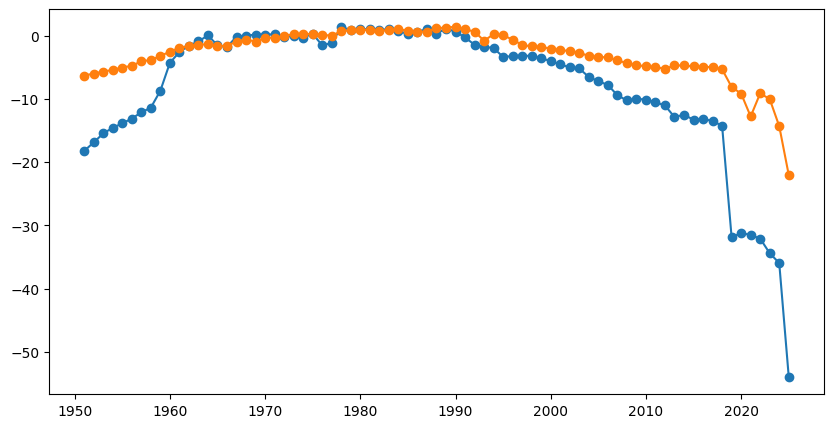

In [ ]:
import matplotlib.pyplot as plt

# Define which components to plot
#climate_components = ['Temperature_Avg', 'Rx5day', 'sfcWind', 'CWD', 'DTR']  
climate_components = ['Temperature_Avg', 'Rx5day', 'CWD', 'DTR']  

# Plot each climate index component over time
plt.figure(figsize=(10, 5))

for component in climate_components:
    plt.plot(standardized.index, standardized[component], marker='o', linestyle='-', label=component)

# Optional: Add a 5-year moving average for smoothing
for component in climate_components:
    plt.plot(standardized.index, standardized[component].rolling(window=5, center=True, min_periods=5).mean(),
             linestyle='--', alpha=0.7, label=f"{component} (5yr MA)")

# Formatting the plot
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Reference line at zero
plt.xlabel('Year')
plt.ylabel('Standardized Anomaly (σ)')
plt.title('Time Series of Climate Index Components')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



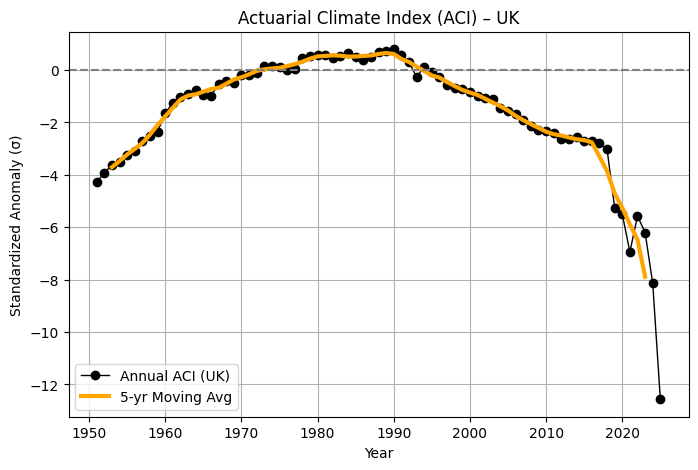

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(standardized.index, standardized['ACI_Combine'], label='Annual ACI (UK)', color='black', marker='o', lw=1)
plt.plot(standardized.index, standardized['ACI_5yr_MA'], label='5-yr Moving Avg', color='orange', lw=3)
plt.axhline(0, color='gray', linestyle='--')  # reference baseline
plt.title('Actuarial Climate Index (ACI) – UK')
plt.ylabel('Standardized Anomaly (σ)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()


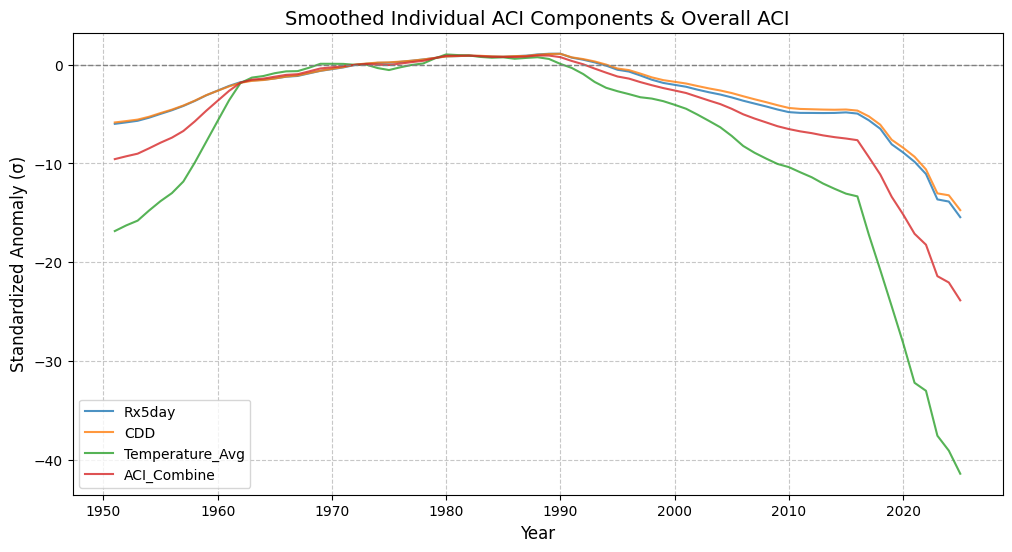

        Rx5day       CDD  Temperature_Avg  ACI_Combine
Year                                                  
1951 -5.998775 -5.856560       -16.848738    -9.568024
1952 -5.847840 -5.717511       -16.276997    -9.280783
1953 -5.687284 -5.568181       -15.794081    -9.016515
1954 -5.375554 -5.278811       -14.771245    -8.475203
1955 -4.990941 -4.906445       -13.821953    -7.906446
1956 -4.620039 -4.556377       -13.005995    -7.394137
1957 -4.186359 -4.142638       -11.834665    -6.721221
1958 -3.680518 -3.652840        -9.920978    -5.751445
1959 -3.114062 -3.094416        -7.817150    -4.675209
1960 -2.634920 -2.649708        -5.709038    -3.664555


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the baseline reference period
ref_start, ref_end = 1961, 1990
baseline_mask = (uk_df.index >= ref_start) & (uk_df.index <= ref_end)

# Compute mean and standard deviation over reference period
baseline_means = uk_df[baseline_mask].mean()
baseline_stds = uk_df[baseline_mask].std(ddof=0)  # Population standard deviation

# Standardize each index component (Z-score transformation)
individual_acis = (uk_df - baseline_means) / baseline_stds

# Adjust cold spell index (sfcWind) since fewer cold spells = warming
if 'sfcWind' in individual_acis.columns:
    individual_acis['sfcWind'] = -individual_acis['sfcWind']

# Compute overall ACI (mean of all standardized components)
individual_acis["ACI_Combine"] = individual_acis.mean(axis=1)

# Apply a 5-year moving average for smoothing
smoothed_acis = individual_acis.rolling(window=5, center=True, min_periods=3).mean()

# Plot individual smoothed components
plt.figure(figsize=(12, 6))
for component in smoothed_acis.columns:
    plt.plot(smoothed_acis.index, smoothed_acis[component], linestyle='-', alpha=0.8, label=component)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Reference line at zero
plt.xlabel('Year', fontsize=12)
plt.ylabel('Standardized Anomaly (σ)', fontsize=12)
plt.title('Smoothed Individual ACI Components & Overall ACI', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Display a summary table of smoothed ACI values
print(smoothed_acis.head(10))  # Display first 10 years for verification



Spatial Pattern of Climate Anomalies over the UK

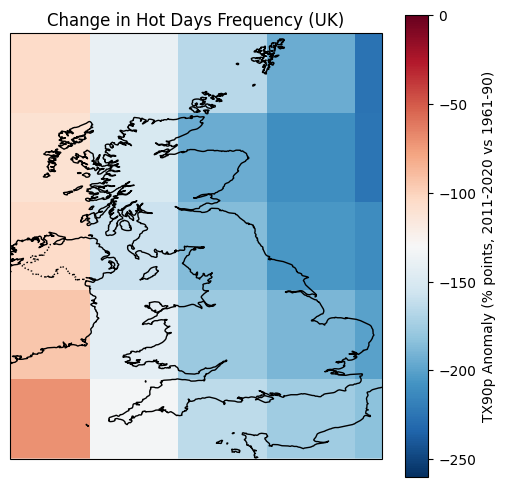

In [ ]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Extract lat/lon indices from dataset
lat_min_uk, lat_max_uk = 49.0, 61.0
lon_min_uk, lon_max_uk = -8.5, 2.0

# Load latitude and longitude arrays
lats = datasets["TX90p"].variables["lat"][:]
lons = datasets["TX90p"].variables["lon"][:]

# Convert UK longitude bounds to 0-360 if needed
lon_min_mod = lon_min_uk + 360 if lon_min_uk < 0 else lon_min_uk
lon_max_mod = lon_max_uk + 360 if lon_max_uk < 0 else lon_max_uk

# Find the indices corresponding to the UK region
lat_indices = np.where((lats >= lat_min_uk) & (lats <= lat_max_uk))[0]
if lon_min_mod <= lon_max_mod:
    lon_indices = np.where((lons >= lon_min_mod) & (lons <= lon_max_mod))[0]
else:
    lon_indices = np.where((lons >= lon_min_mod) | (lons <= lon_max_mod))[0]

# Extract UK-specific lat/lon values
uk_lats = lats[lat_indices.min():lat_indices.max() + 1]
uk_lons = lons[lon_indices.min():lon_indices.max() + 1]

# Compute TX90p anomaly for 2011-2020 vs 1961-1990 baseline
tx90p_all = datasets["TX90p"].variables["Ann"][:]  # Shape: [time, lat, lon]
baseline_mask = (years >= 1961) & (years <= 1990)
recent_mask = (years >= 2011) & (years <= 2020)

# Compute mean values over the reference and recent periods
baseline_avg_map = np.nanmean(tx90p_all[baseline_mask, :, :], axis=0)
recent_avg_map = np.nanmean(tx90p_all[recent_mask, :, :], axis=0)

# Compute anomaly
tx90p_anomaly_map = recent_avg_map - baseline_avg_map

# Extract UK region anomaly map
uk_tx90p_change = tx90p_anomaly_map[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]

# Create a plot
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min_uk, lon_max_uk, lat_min_uk, lat_max_uk])

# Add coastlines and borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot anomaly
lon_grid, lat_grid = np.meshgrid(uk_lons, uk_lats)
cs = ax.pcolormesh(lon_grid, lat_grid, uk_tx90p_change, cmap='RdBu_r', transform=ccrs.PlateCarree())

# Add a color bar
plt.colorbar(cs, ax=ax, orientation='vertical', label='TX90p Anomaly (% points, 2011-2020 vs 1961-90)')

# Set title
plt.title('Change in Hot Days Frequency (UK)')

# Show plot
plt.show()


In [ ]:
# Compute spatial anomaly for TX90p: recent decade (2011-2020) vs 1961-1990 baseline
recent_mask = (uk_df.index >= 2011) & (uk_df.index <= 2020)
# Average TX90p over baseline and recent period for each grid cell:
tx90p_all = datasets["TX90p"].variables["Ann"][:]  # [year, lat, lon] original TX90p values per grid
baseline_avg_map = np.nanmean(tx90p_all[baseline_mask, :, :], axis=0)
recent_avg_map   = np.nanmean(tx90p_all[recent_mask, :, :], axis=0)
tx90p_anomaly_map = recent_avg_map - baseline_avg_map  # difference in % of hot days

# Focus on UK region subset of this map:
uk_lat_slice = slice(lat_indices.min(), lat_indices.max()+1)
uk_lon_slice = slice(lon_indices.min(), lon_indices.max()+1)
uk_tx90p_change = tx90p_anomaly_map[uk_lat_slice, uk_lon_slice]
uk_lats = lats[lat_indices.min():lat_indices.max()+1]
uk_lons = lons[lon_indices.min():lon_indices.max()+1]

# Plot the spatial anomaly
#%pip install basemap

from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(6,6))
m = Basemap(projection='merc', llcrnrlat=lat_min_uk, urcrnrlat=lat_max_uk, 
            llcrnrlon=lon_min_uk, urcrnrlon=lon_max_uk, resolution='l')
lon_grid, lat_grid = np.meshgrid(uk_lons, uk_lats)
x, y = m(lon_grid, lat_grid)
# Plot anomaly as colored mesh
cs = m.pcolormesh(x, y, uk_tx90p_change, cmap='RdBu_r', shading='auto')
m.drawcoastlines(); m.drawcountries()
plt.colorbar(cs, label='TX90p Anomaly (% points, 2011-2020 vs 1961-90)')
plt.title('Change in Hot Days Frequency (UK)')
plt.show()


ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

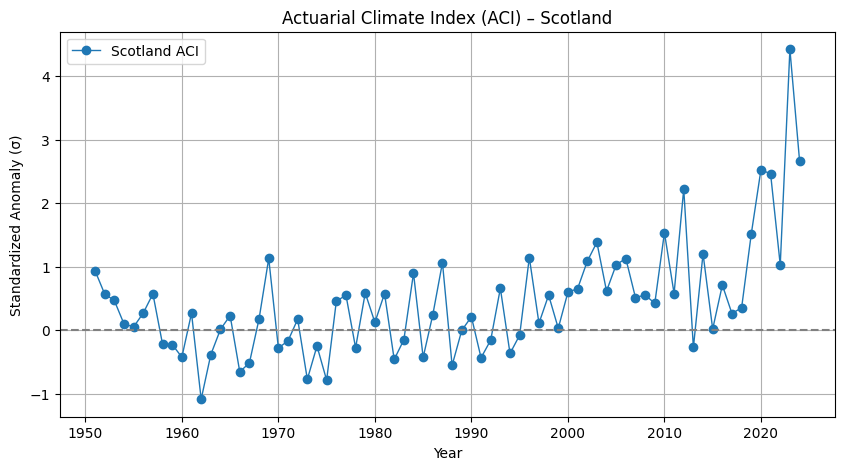

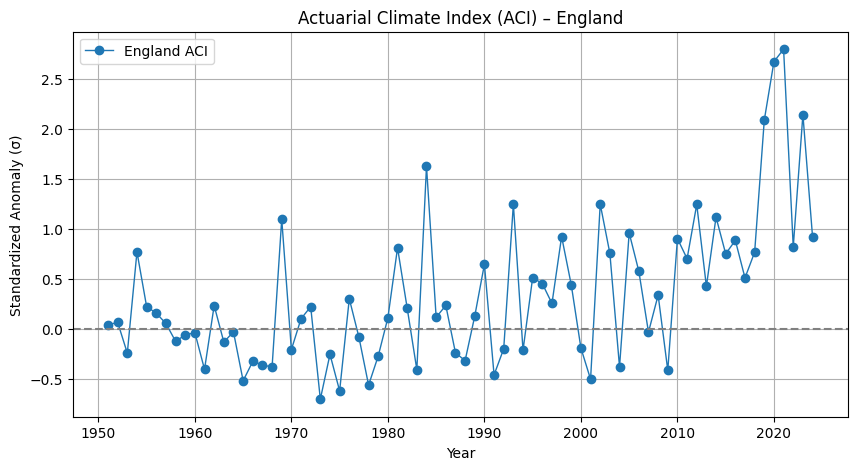

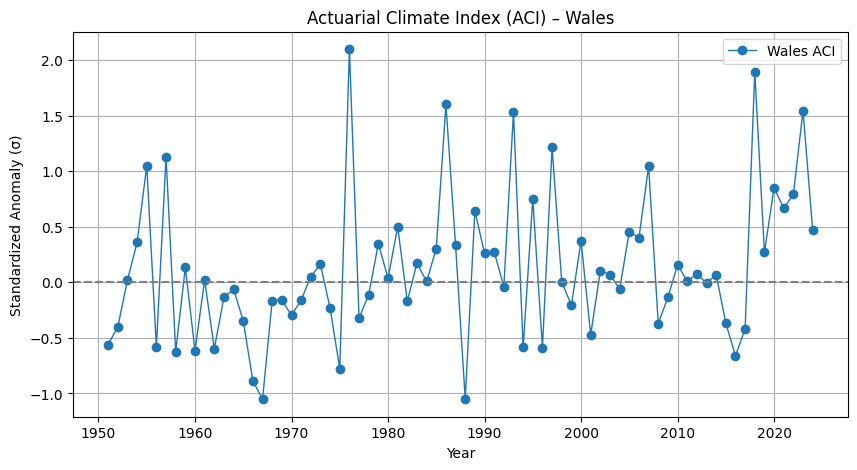

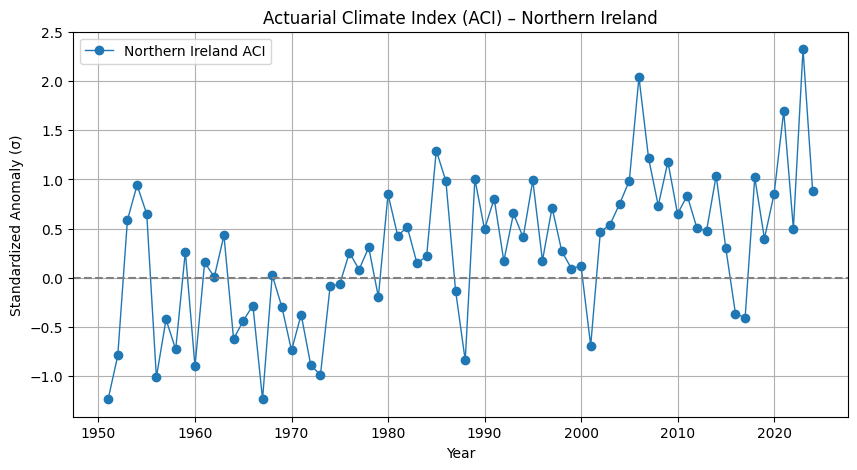

In [14]:
# Define region boundaries based on latitude and longitude
regions = {
    'Scotland': {'lat_min': 56, 'lat_max': 60, 'lon_min': -5, 'lon_max': 0},
    'England': {'lat_min': 50, 'lat_max': 56, 'lon_min': -6, 'lon_max': 2},
    'Wales': {'lat_min': 51, 'lat_max': 53, 'lon_min': -5, 'lon_max': -3},
    'Northern Ireland': {'lat_min': 54, 'lat_max': 56, 'lon_min': -7, 'lon_max': -5}
}

# Function to get indices for a given region
def get_region_indices(region, lats, lons):
    lat_indices = np.where((lats >= region['lat_min']) & (lats <= region['lat_max']))[0]
    lon_min_mod = region['lon_min'] + 360 if region['lon_min'] < 0 else region['lon_min']
    lon_max_mod = region['lon_max'] + 360 if region['lon_max'] < 0 else region['lon_max']

    if lon_min_mod <= lon_max_mod:
        lon_indices = np.where((lons >= lon_min_mod) & (lons <= lon_max_mod))[0]
    else:
        lon_indices = np.where((lons >= lon_min_mod) | (lons <= lon_max_mod))[0]

    return lat_indices, lon_indices

# Initialize dictionary to store results for each region
regional_aci = {}

# Loop over regions
for region_name, region_bounds in regions.items():
    lat_indices, lon_indices = get_region_indices(region_bounds, lats, lons)
    
    # For each climate index component, calculate the regional ACI
    region_aci = {}

    for name, ds in datasets.items():
        # Annual data for all years and all grid cells
        annual_data = ds.variables["Ann"][:]  # shape: [time, lat, lon]
        # Subset data for the region
        region_data = annual_data[:, lat_indices.min():lat_indices.max() + 1, lon_indices.min():lon_indices.max() + 1]
        # Compute spatial average for the region
        region_mean = np.nanmean(region_data, axis=(1, 2))
        region_aci[name] = region_mean

    # Convert to pandas DataFrame for convenience
    region_df = pd.DataFrame(region_aci, index=years)
    region_df.index.name = "Year"

    # Calculate the average temperature index
    region_df['Temperature_Avg'] = region_df[['TN90p', 'TN10p', 'TX90p', 'TX10p']].mean(axis=1)

    # Remove the TX and TN columns
    region_df = region_df.drop(columns=['TX90p', 'TX10p', 'TN90p', 'TN10p'])

    # Standardize for each region using the baseline reference period (1961-1990)
    baseline_mask = (region_df.index >= ref_start) & (region_df.index <= ref_end)
    baseline_means = region_df[baseline_mask].mean()
    baseline_stds = region_df[baseline_mask].std(ddof=0)  # population std over ref period

    # Standardize each component for the region
    standardized_region = (region_df - baseline_means) / baseline_stds

    # Invert the Cold Spell Duration Index (CSDI)
    if 'CSDI' in standardized_region.columns:
        standardized_region['CSDI'] = -standardized_region['CSDI']

    # Compute the Actuarial Climate Index (ACI) as the average of the standardized components
    standardized_region['ACI_Combine'] = standardized_region.mean(axis=1)

    # Store the regional ACI in the dictionary
    regional_aci[region_name] = standardized_region

    # Optionally plot or save the regional results
    plt.figure(figsize=(10, 5))
    plt.plot(standardized_region.index, standardized_region['ACI_Combine'], label=f'{region_name} ACI', marker='o', lw=1)
    plt.axhline(0, color='gray', linestyle='--')  # reference baseline
    plt.title(f'Actuarial Climate Index (ACI) – {region_name}')
    plt.ylabel('Standardized Anomaly (σ)')
    plt.xlabel('Year')
    plt.legend()
    plt.grid(True)
    plt.show()

# Optionally save each regional ACI to CSV
for region_name, region_df in regional_aci.items():
    region_df.to_csv(f"{region_name}_ACI.csv")




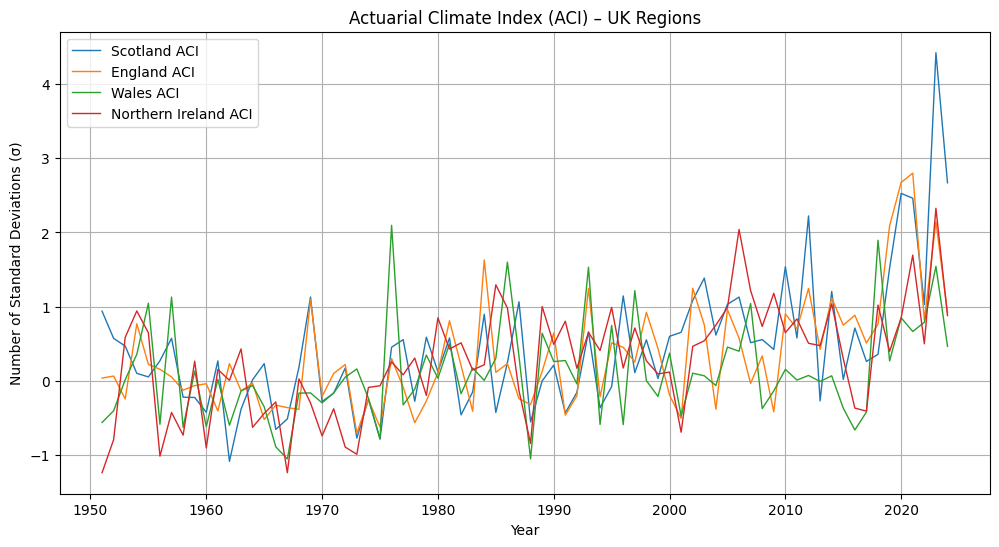

In [15]:
# Initialize the figure for all regional ACI plots
plt.figure(figsize=(12, 6))


# Loop over regions and plot their ACI
for region_name, region_df in regional_aci.items():
    plt.plot(region_df.index, region_df['ACI_Combine'], label=f'{region_name} ACI', lw=1)

# Add horizontal line at ACI = 0 for reference
plt.axhline(0, color='gray', linestyle='', linewidth=1)

# Add labels, title, and legend
plt.title('Actuarial Climate Index (ACI) – UK Regions')
plt.ylabel('Number of Standard Deviations (σ)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)

# Show the plot with all regional ACI curves
plt.show()
